<a href="https://colab.research.google.com/github/CA683-Group99/Wind-Energy-Prediction/blob/main/4_IslandElectricityANNModel_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir('/content/drive/MyDrive/CA683Project')
# CL os.chdir('/content/drive/MyDrive/Colab Notebooks/CA683Project')

Mounted at /content/drive


In [2]:

from datetime import tzinfo, timedelta, datetime, date

# Load data

In [3]:
# Cut off dates
cutOffTestDate = "2021-03-15"
max_date = "2021-03-30"

In [4]:
import pandas as pd

inFilename = 'IslandElectricity2017_2020v4.csv'
filePath = 'Data/' + inFilename
inData = pd.read_csv(filePath)
#inData = pd.read_csv(inFilename)

print('-----------DATA INFO -------------')
print(inData.info())

display(inData.head())


inData.date = pd.to_datetime(inData.date, format='%Y-%m-%d %H:%M', errors='ignore')
inData.isweekday = inData.isweekday.astype('bool')

-----------DATA INFO -------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33600 entries, 0 to 33599
Data columns (total 77 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Unnamed: 0           33600 non-null  int64  
 1   date                 33600 non-null  object 
 2   rain_BEL             33600 non-null  float64
 3   temp_BEL             33600 non-null  float64
 4   wetb_BEL             33600 non-null  float64
 5   dewpt_BEL            33600 non-null  float64
 6   vappr_BEL            33600 non-null  float64
 7   rhum_BEL             33600 non-null  int64  
 8   msl_BEL              33600 non-null  float64
 9   wdsp_BEL             33600 non-null  int64  
 10  wddir_BEL            33600 non-null  int64  
 11  rain_DUB             33600 non-null  float64
 12  temp_DUB             33600 non-null  float64
 13  wetb_DUB             33600 non-null  float64
 14  dewpt_DUB            33600 non-null  float64
 15  v

,Unnamed: 0,date,rain_BEL,temp_BEL,wetb_BEL,dewpt_BEL,vappr_BEL,rhum_BEL,msl_BEL,wdsp_BEL,wddir_BEL,rain_DUB,temp_DUB,wetb_DUB,dewpt_DUB,vappr_DUB,rhum_DUB,msl_DUB,wdsp_DUB,wddir_DUB,ww_DUB,w_DUB,sun_DUB,vis_DUB,clht_DUB,clamt_DUB,rain,temp,wetb,dewpt,vappr,rhum,msl,wdsp,wddir,ww,w,sun,vis,clht,clamt,rain_COR,temp_COR,wetb_COR,dewpt_COR,vappr_COR,rhum_COR,msl_COR,wdsp_COR,wddir_COR,ww_COR,w_COR,sun_COR,vis_COR,clht_COR,clamt_COR,rain_MAL,temp_MAL,wetb_MAL,dewpt_MAL,vappr_MAL,rhum_MAL,msl_MAL,wdsp_MAL,wddir_MAL,Unnamed: 0.1,ActualDemandMW,ForecastWndMW,ActualWindMW,ActualGenerationMW,NetTotal_MW,WindMWPercent,hour,isweekday,month,year,TotalWindCapacityMW
0,0,2017-07-01 00:00:00,0.0,12.3,11.3,10.3,12.5,88,1017.6,8,200,0.0,8.5,7.4,6.2,9.4,85,1018.0,7,270,2,11,0.0,40000,999,1,0.0,10.6,9.5,8.4,11.0,86,1020.1,6,260,2,11,0.0,30000,999,0,0.0,10.0,8.7,7.2,10.2,83,1020.7,7,280,2,11,0.0,30000.0,999,2,0.0,9.9,8.7,7.3,10.2,84,1016.8,10,270.0,0.0,2394.75,287.0,280.25,2580.75,-221.00,11.702683,0.0,False,7.0,2017.0,4096.494
1,1,2017-07-01 01:00:00,0.0,12.5,11.4,10.4,12.6,87,1016.9,10,200,0.0,8.0,7.0,5.9,9.2,86,1018.2,9,270,2,11,0.0,40000,999,1,0.0,10.4,9.5,8.5,11.1,88,1019.8,4,240,2,11,0.0,30000,999,2,0.0,9.6,8.3,6.8,9.9,83,1020.5,7,280,2,11,0.0,30000.0,999,1,0.0,10.0,8.8,7.5,10.3,84,1016.2,10,260.0,1.0,2961.50,319.5,423.25,3402.00,-406.75,14.291744,1.0,False,7.0,2017.0,4096.494
2,2,2017-07-01 02:00:00,0.0,13.0,11.9,10.9,13.0,86,1016.2,14,200,0.0,7.5,6.9,6.2,9.5,91,1018.0,8,270,2,11,0.0,40000,999,1,0.0,10.0,9.5,9.0,11.5,93,1019.6,2,190,2,11,0.0,30000,999,2,0.0,9.7,8.4,7.0,10.0,83,1020.2,7,280,2,11,0.0,30000.0,999,1,0.0,10.0,9.2,8.3,10.9,88,1015.8,10,220.0,2.0,2785.25,320.0,451.25,3411.75,-388.00,16.201418,2.0,False,7.0,2017.0,4096.494
3,3,2017-07-01 03:00:00,0.0,12.9,12.0,11.2,13.3,89,1015.6,16,210,0.0,7.2,6.7,6.1,9.4,93,1018.0,9,270,2,11,0.0,60000,999,0,0.0,11.1,10.2,9.4,11.7,89,1018.8,5,190,2,11,0.0,20000,23,7,0.0,8.8,7.9,6.9,9.9,88,1019.9,4,280,2,11,0.0,30000.0,999,1,0.0,8.9,8.1,7.2,10.1,89,1015.4,10,190.0,3.0,2716.25,347.5,512.75,3500.00,-534.75,18.877128,3.0,False,7.0,2017.0,4096.494
4,4,2017-07-01 04:00:00,0.0,13.3,12.7,12.2,14.2,93,1015.0,17,210,0.0,7.6,7.0,6.3,9.5,91,1017.7,8,250,2,11,0.0,60000,999,1,0.0,11.5,10.4,9.4,11.7,86,1018.3,4,170,2,11,0.0,20000,23,7,0.0,8.5,7.6,6.6,9.7,88,1019.6,5,270,2,11,0.0,30000.0,18,5,0.0,8.7,7.9,7.0,10.0,89,1015.2,10,190.0,4.0,2654.00,410.5,576.75,3330.00,-430.50,21.731349,4.0,False,7.0,2017.0,4096.494


## Transform wind speed and dir into 2D wind vector

In [5]:
import math

suffixes = ['_COR', '_DUB', '_BEL', '', '_MAL']
def transformWindInto2d(df):
  for suf in suffixes:
    df['wind' + suf + 'sin'] = None
    df['wind' + suf + 'cos'] = None

  def transformWindInto2dRow(row):
    for suf in suffixes:
      row['wind' + suf + 'sin'] = row['wdsp'+ suf] * math.sin(row['wddir' + suf])
      row['wind' + suf + 'cos'] = row['wdsp'+ suf] * math.cos(row['wddir' + suf])
    return row

  df = df.apply(transformWindInto2dRow, axis='columns')
  return df

inData = transformWindInto2d(inData)
inData.columns

Index(['Unnamed: 0', 'date', 'rain_BEL', 'temp_BEL', 'wetb_BEL', 'dewpt_BEL',
       'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL', 'wddir_BEL', 'rain_DUB',
       'temp_DUB', 'wetb_DUB', 'dewpt_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB',
       'wdsp_DUB', 'wddir_DUB', 'ww_DUB', 'w_DUB', 'sun_DUB', 'vis_DUB',
       'clht_DUB', 'clamt_DUB', 'rain', 'temp', 'wetb', 'dewpt', 'vappr',
       'rhum', 'msl', 'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht',
       'clamt', 'rain_COR', 'temp_COR', 'wetb_COR', 'dewpt_COR', 'vappr_COR',
       'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR', 'ww_COR', 'w_COR',
       'sun_COR', 'vis_COR', 'clht_COR', 'clamt_COR', 'rain_MAL', 'temp_MAL',
       'wetb_MAL', 'dewpt_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL',
       'wddir_MAL', 'Unnamed: 0.1', 'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW', 'ActualGenerationMW', 'NetTotal_MW', 'WindMWPercent',
       'hour', 'isweekday', 'month', 'year', 'TotalWindCapacityMW',
       'wind_CORs

Text(0, 0.5, 'Wind Velocity [m/s]')

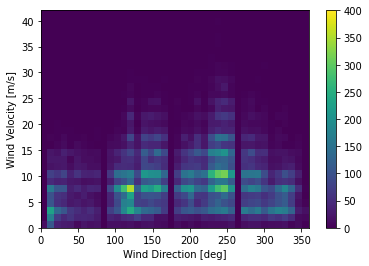

In [6]:
import matplotlib.pyplot as plt
plt.hist2d(inData['wddir'], inData['wdsp'], bins=(40, 30), vmax=400)
plt.colorbar()
plt.xlabel('Wind Direction [deg]')
plt.ylabel('Wind Velocity [m/s]')

## Transform time into 2D

Intend to capture the seasonal pattern

In [7]:
import numpy as np
import math

def transformTimeInto2d(df):
  df['Day_inYear'] = None
  df['daysInYear'] = None
  df['radianTime'] = None
  df['radianTimeCos'] = None
  df['radianTimeSin'] = None
  df['hourCos'] = None
  df['hourSin'] = None

  def check_leap(year):
    if year%4 == 0:
      return 366
    else:
      return 365

  def transformTimeInto2dRow(row):
    row['Day_inYear'] = row['date'].timetuple().tm_yday
    daysInYear = check_leap(row['year'])
    row['daysInYear'] = daysInYear
    row['radianTime'] = (row.hour + row.Day_inYear * 24 ) / (24 * daysInYear) * (2*np.pi)
    row['radianTimeCos'] = math.cos(row['radianTime'])
    row['radianTimeSin'] = math.sin(row['radianTime'])
    row['hourCos'] = math.cos(row.hour/24 * (2*np.pi))
    row['hourSin'] = math.sin(row.hour/24 * (2*np.pi))
    return row

  df = df.apply(transformTimeInto2dRow, axis='columns')
  return df

inData = transformTimeInto2d(inData)
inData.columns

Index(['Unnamed: 0', 'date', 'rain_BEL', 'temp_BEL', 'wetb_BEL', 'dewpt_BEL',
       'vappr_BEL', 'rhum_BEL', 'msl_BEL', 'wdsp_BEL', 'wddir_BEL', 'rain_DUB',
       'temp_DUB', 'wetb_DUB', 'dewpt_DUB', 'vappr_DUB', 'rhum_DUB', 'msl_DUB',
       'wdsp_DUB', 'wddir_DUB', 'ww_DUB', 'w_DUB', 'sun_DUB', 'vis_DUB',
       'clht_DUB', 'clamt_DUB', 'rain', 'temp', 'wetb', 'dewpt', 'vappr',
       'rhum', 'msl', 'wdsp', 'wddir', 'ww', 'w', 'sun', 'vis', 'clht',
       'clamt', 'rain_COR', 'temp_COR', 'wetb_COR', 'dewpt_COR', 'vappr_COR',
       'rhum_COR', 'msl_COR', 'wdsp_COR', 'wddir_COR', 'ww_COR', 'w_COR',
       'sun_COR', 'vis_COR', 'clht_COR', 'clamt_COR', 'rain_MAL', 'temp_MAL',
       'wetb_MAL', 'dewpt_MAL', 'vappr_MAL', 'rhum_MAL', 'msl_MAL', 'wdsp_MAL',
       'wddir_MAL', 'Unnamed: 0.1', 'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW', 'ActualGenerationMW', 'NetTotal_MW', 'WindMWPercent',
       'hour', 'isweekday', 'month', 'year', 'TotalWindCapacityMW',
       'wind_CORs

# Data preparation

## Select data for training and testing

In [8]:
# CL END CHANGE 

In [9]:
# CL Change : take all data
attrs = ['date', 'hour', 'month', 'year', 'Day_inYear',
          'wdsp_BEL', 'wddir_BEL', 'wind_BELsin', 'wind_BELcos','vappr_BEL', 'rhum_BEL', 'temp_BEL',
          'wdsp', 'wddir', 'windsin', 'windcos', 'vappr', 'rhum', 'temp', 'msl',
          'wdsp_COR', 'wddir_COR', 'wind_CORsin', 'wind_CORcos', 'vappr_COR', 'rhum_COR', 'temp_COR',
          'wdsp_DUB', 'wddir_DUB', 'wind_DUBsin', 'wind_DUBcos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB',
          'wdsp_MAL', 'wddir_MAL', 'wind_MALsin', 'wind_MALcos', 'vappr_MAL', 'rhum_MAL', 'temp_MAL',
          'TotalWindCapacityMW',
          'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
          'ActualWindMW', 'ActualDemandMW', 'ForecastWndMW']

# (inData.year<=2021)
dataSet = inData.loc[(inData.year>=2017) & (inData.date < max_date), attrs]

## Handle the rows with empty values

In [10]:
# CL Change : fill in missing Rhum and vappr values as quick fix
dataSet.isnull().sum()

date                   0
hour                   0
month                  0
year                   0
Day_inYear             0
wdsp_BEL               0
wddir_BEL              0
wind_BELsin            0
wind_BELcos            0
vappr_BEL              0
rhum_BEL               0
temp_BEL               0
wdsp                   0
wddir                  0
windsin                0
windcos                0
vappr                  0
rhum                   0
temp                   0
msl                    0
wdsp_COR               0
wddir_COR              0
wind_CORsin            0
wind_CORcos            0
vappr_COR              0
rhum_COR               0
temp_COR               0
wdsp_DUB               0
wddir_DUB              0
wind_DUBsin            0
wind_DUBcos            0
vappr_DUB              0
rhum_DUB               0
temp_DUB               0
wdsp_MAL               0
wddir_MAL              0
wind_MALsin            0
wind_MALcos            0
vappr_MAL              0
rhum_MAL               0


In [11]:
# dataSet.fillna(method='ffill', limit=4, inplace=True)

# Remove the rows with empty cells
import numpy as np
eIdx = np.where(pd.isnull(dataSet))
print(eIdx[0])

print(dataSet.shape)
dataSet = dataSet.drop(eIdx[0], axis=0)
print(dataSet.shape)

[]
(32832, 49)
(32832, 49)


In [12]:
dataSet.tail()

,date,hour,month,year,Day_inYear,wdsp_BEL,wddir_BEL,wind_BELsin,wind_BELcos,vappr_BEL,rhum_BEL,temp_BEL,wdsp,wddir,windsin,windcos,vappr,rhum,temp,msl,wdsp_COR,wddir_COR,wind_CORsin,wind_CORcos,vappr_COR,rhum_COR,temp_COR,wdsp_DUB,wddir_DUB,wind_DUBsin,wind_DUBcos,vappr_DUB,rhum_DUB,temp_DUB,wdsp_MAL,wddir_MAL,wind_MALsin,wind_MALcos,vappr_MAL,rhum_MAL,temp_MAL,TotalWindCapacityMW,radianTimeSin,radianTimeCos,hourSin,hourCos,ActualWindMW,ActualDemandMW,ForecastWndMW
32827,2021-03-29 19:00:00,19.0,3.0,2021.0,88,26,200,-22.705730,12.666880,12.0,89,11.3,10,190,9.977993,0.663069,11.0,73,13.2,1021.1,12,200,-10.479568,5.846252,11.9,97,9.9,11,200,-9.606270,5.359064,11.2,80,12.0,15,200.0,-13.099459,7.307815,12.5,85,12.7,5576.095,0.999105,0.042306,-0.965926,0.258819,3220.25,5023.00,3608.50
32828,2021-03-29 20:00:00,20.0,3.0,2021.0,88,24,200,-20.959135,11.692504,12.0,90,11.1,10,190,9.977993,0.663069,11.0,76,12.4,1021.7,13,200,-11.352865,6.333440,11.7,99,9.5,10,200,-8.732973,4.871877,11.1,81,11.7,19,210.0,8.886652,-16.793672,11.9,82,12.5,5576.095,0.999135,0.041589,-0.866025,0.500000,3120.75,5090.75,3502.75
32829,2021-03-29 21:00:00,21.0,3.0,2021.0,88,24,200,-20.959135,11.692504,11.9,91,10.9,5,130,-4.650530,-1.836457,11.4,82,11.9,1022.4,12,190,11.973591,0.795682,11.7,100,9.3,11,220,0.972386,10.956937,11.5,84,11.6,20,210.0,9.354370,-17.677549,11.5,80,12.3,5576.095,0.999164,0.040872,-0.707107,0.707107,3040.75,4848.25,3367.00
32830,2021-03-29 22:00:00,22.0,3.0,2021.0,88,22,200,-19.212541,10.718129,12.0,91,10.9,3,110,-0.132728,-2.997062,11.6,84,11.7,1022.7,10,190,9.977993,0.663069,11.4,99,9.1,12,220,1.060785,11.953022,11.5,83,11.8,17,200.0,-14.846054,8.282190,11.5,80,12.3,5576.095,0.999193,0.040156,-0.500000,0.866025,2999.00,4351.75,3223.00
32831,2021-03-29 23:00:00,23.0,3.0,2021.0,88,23,190,22.949383,1.525058,12.0,92,10.8,8,160,1.755402,-7.805035,12.0,83,12.4,1023.1,9,190,8.980194,0.596762,11.3,100,8.8,11,220,0.972386,10.956937,11.2,82,11.7,18,190.0,17.960387,1.193523,11.3,79,12.2,5576.095,0.999222,0.039439,-0.258819,0.965926,2620.50,3881.50,3067.75


## Add columns with ActualWindMW shifted by 24 hours

In [13]:
target_cols = ['ActualWindMW', 'ActualDemandMW']

for weatherCol in target_cols:
  dataSet[weatherCol + "_shift"] = dataSet[weatherCol].shift(24)

dataSet.isnull().sum()

date                     0
hour                     0
month                    0
year                     0
Day_inYear               0
wdsp_BEL                 0
wddir_BEL                0
wind_BELsin              0
wind_BELcos              0
vappr_BEL                0
rhum_BEL                 0
temp_BEL                 0
wdsp                     0
wddir                    0
windsin                  0
windcos                  0
vappr                    0
rhum                     0
temp                     0
msl                      0
wdsp_COR                 0
wddir_COR                0
wind_CORsin              0
wind_CORcos              0
vappr_COR                0
rhum_COR                 0
temp_COR                 0
wdsp_DUB                 0
wddir_DUB                0
wind_DUBsin              0
wind_DUBcos              0
vappr_DUB                0
rhum_DUB                 0
temp_DUB                 0
wdsp_MAL                 0
wddir_MAL                0
wind_MALsin              0
w

In [14]:
dataSet[['ActualWindMW', 'ActualWindMW_shift', 'ActualDemandMW_shift']].head(25)


,ActualWindMW,ActualWindMW_shift,ActualDemandMW_shift
0,280.25,NaN,NaN
1,423.25,NaN,NaN
2,451.25,NaN,NaN
3,512.75,NaN,NaN
4,576.75,NaN,NaN
5,626.00,NaN,NaN
6,700.25,NaN,NaN
7,743.50,NaN,NaN
8,805.25,NaN,NaN
9,1044.00,NaN,NaN


In [15]:
print(dataSet.shape)

dataSet.dropna(axis=0, inplace=True)
print(dataSet.shape)

(32832, 51)
(32808, 51)


## Different feature sets to build different ANN models

In [16]:
# CL: 2021/04/02: remove Hour as very highly correlated with Day_inYear, as well as temp other than temp_DUB
# and add 'msl' Sea Level pressure as highly predictive of upcoming storm and improve wind turbine performance
# add Malin Head wind
# CL: 2021/04/02: remove Hour as very highly correlated with Day_inYear, as well as temp other than temp_DUB
# and add 'msl' Sea Level pressure as highly predictive of upcoming storm and improve wind turbine performance
attr_basic = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL',
              'wdsp', 'wddir',
              'wdsp_COR', 'wddir_COR',
              'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW']

attr_shifted = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL',
              'wdsp', 'wddir',
              'wdsp_COR', 'wddir_COR',
              'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW', 'ActualWindMW_shift']

attr_rhum = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL', 'rhum_BEL',
              'wdsp', 'wddir', 'rhum',
              'wdsp_COR', 'wddir_COR', 'rhum_COR',
              'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL', 'rhum_MAL',
              'TotalWindCapacityMW']

# attr_vappr = ['hour', 'Day_inYear',
#               'wdsp_BEL', 'wddir_BEL', 'vappr_BEL',
#               'wdsp', 'wddir', 'vappr',
#               'wdsp_COR', 'wddir_COR', 'vappr_COR',
#               'wdsp_DUB', 'wddir_DUB', 'vappr_DUB', 'temp_DUB',
#               'wdsp_MAL', 'wddir_MAL', 'vappr_MAL',
#               'TotalWindCapacityMW']

attr_msl = ['hour', 'Day_inYear',
              'wdsp_BEL', 'wddir_BEL',
              'wdsp', 'wddir', 'msl',
              'wdsp_COR', 'wddir_COR',
              'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
              'wdsp_MAL', 'wddir_MAL',
              'TotalWindCapacityMW']

# attr_rhum_vappr = ['hour', 'Day_inYear',
#                     'wdsp_BEL', 'wddir_BEL', 'rhum_BEL', 'vappr_BEL',
#                     'wdsp', 'wddir', 'rhum', 'vappr',
#                     'wdsp_COR', 'wddir_COR', 'rhum_COR', 'vappr_COR',
#                     'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'vappr_DUB', 'temp_DUB',
#                     'wdsp_MAL', 'wddir_MAL', 'rhum_MAL', 'vappr_MAL',
#                     'TotalWindCapacityMW']

attr_rhum_msl = ['hour', 'Day_inYear',
                    'wdsp_BEL', 'wddir_BEL', 'rhum_BEL',
                    'wdsp', 'wddir', 'rhum', 'msl',
                    'wdsp_COR', 'wddir_COR', 'rhum_COR',
                    'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
                    'wdsp_MAL', 'wddir_MAL', 'rhum_MAL',
                    'TotalWindCapacityMW']

attr_2D_wind = ['hour', 'Day_inYear',
                'wind_BELsin', 'wind_BELcos',
                'windsin', 'windcos',
                'wind_CORsin', 'wind_CORcos',
                'wind_DUBsin', 'wind_DUBcos', 'temp_DUB',
                'wind_MALsin', 'wind_MALcos',
                'TotalWindCapacityMW']

attr_radianTime = ['wdsp_BEL', 'wddir_BEL',
                    'wdsp', 'wddir',
                    'wdsp_COR', 'wddir_COR',
                    'wdsp_DUB', 'wddir_DUB', 'temp_DUB',
                    'wdsp_MAL', 'wddir_MAL',
                    'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
                    'TotalWindCapacityMW']

attr_2D_wind_time = ['wind_BELsin', 'wind_BELcos',
                      'windsin', 'windcos',
                      'wind_CORsin', 'wind_CORcos',
                      'wind_DUBsin', 'wind_DUBcos', 'temp_DUB',
                      'wind_MALsin', 'wind_MALcos',
                      'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
                      'TotalWindCapacityMW']

attr_rhum_time = ['wdsp_BEL', 'wddir_BEL', 'rhum_BEL',
                  'wdsp', 'wddir', 'rhum', 'msl',
                  'wdsp_COR', 'wddir_COR', 'rhum_COR',
                  'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
                  'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
                  'wdsp_MAL', 'wddir_MAL', 'rhum_MAL',
                  'TotalWindCapacityMW']


attr_rhum_time_shift = ['wdsp_BEL', 'wddir_BEL', 'rhum_BEL',
                  'wdsp', 'wddir', 'rhum', 'msl',
                  'wdsp_COR', 'wddir_COR', 'rhum_COR',
                  'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
                  'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
                  'wdsp_MAL', 'wddir_MAL', 'rhum_MAL',
                  'TotalWindCapacityMW', 'ActualWindMW_shift']

# attr_rhum_msl_time = ['wdsp_BEL', 'wddir_BEL', 'rhum_BEL',
#                   'wdsp', 'wddir', 'rhum',
#                   'wdsp_COR', 'wddir_COR', 'rhum_COR',
#                   'wdsp_DUB', 'wddir_DUB', 'rhum_DUB', 'temp_DUB',
#                   'radianTimeSin', 'radianTimeCos', 'hourSin', 'hourCos',
#                   'wdsp_MAL', 'wddir_MAL', 'rhum_MAL',
#                   'TotalWindCapacityMW']


#attr_selections = [attr_basic, attr_shifted, attr_rhum, attr_msl, attr_rhum_msl, attr_2D_wind, attr_radianTime, attr_2D_wind_time, attr_rhum_time]
#attrSet_names = ['basic', 'shifted', 'rhum', 'msl', 'rhum & msl', 'wind', 'radianTime', 'wind & time', 'time & rhum']


#attr_selections = [attr_basic, attr_shifted, attr_2D_wind_time, attr_rhum_time, attr_rhum_time_shift]
#attrSet_names = ['basic', 'basic & prev actual', 'wind & time', 'time & rhum', 'time & rhum & prev actual']

attr_selections = [attr_rhum_time_shift]
attrSet_names = ['time & rhum & prev actual']



In [17]:
# dataframes to store results
df_results = pd.DataFrame(index = ['attrSet', 'algorithm',  
                                   'Valid MAE', 'Valid RMSE', 'Valid explained_variance_score', 
                                   'Test MAE', 'Test RMSE', 'Test explained_variance_score'])

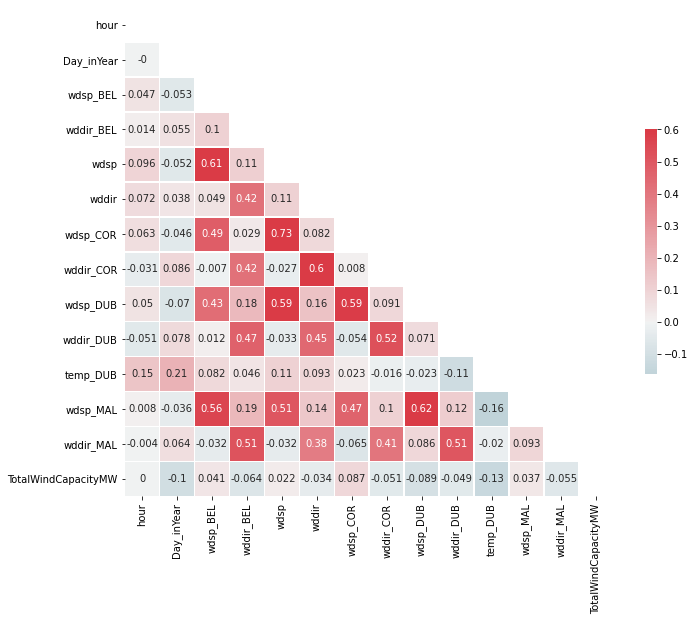

In [18]:
import seaborn as sns

num_df = dataSet.loc[:, attr_basic].select_dtypes(['int', 'float'])
# Compute the correlation matrix
corr = num_df.corr()
corr = np.round(corr, 3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [19]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from patsy import dmatrices
from statsmodels.api import add_constant

num_df = add_constant(num_df)

vif = [variance_inflation_factor(num_df.to_numpy(), i) for i in range(num_df.to_numpy().shape[1])]

pd.DataFrame(num_df.iloc[:, 1:].columns, vif[1:])

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,0
1.040328,hour
1.085083,Day_inYear
1.912806,wdsp_BEL
1.633264,wddir_BEL
2.888518,wdsp
1.767616,wddir
2.455084,wdsp_COR
1.862870,wddir_COR
2.224315,wdsp_DUB
1.761246,wddir_DUB


In [20]:
dataSet.columns

Index(['date', 'hour', 'month', 'year', 'Day_inYear', 'wdsp_BEL', 'wddir_BEL',
       'wind_BELsin', 'wind_BELcos', 'vappr_BEL', 'rhum_BEL', 'temp_BEL',
       'wdsp', 'wddir', 'windsin', 'windcos', 'vappr', 'rhum', 'temp', 'msl',
       'wdsp_COR', 'wddir_COR', 'wind_CORsin', 'wind_CORcos', 'vappr_COR',
       'rhum_COR', 'temp_COR', 'wdsp_DUB', 'wddir_DUB', 'wind_DUBsin',
       'wind_DUBcos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB', 'wdsp_MAL',
       'wddir_MAL', 'wind_MALsin', 'wind_MALcos', 'vappr_MAL', 'rhum_MAL',
       'temp_MAL', 'TotalWindCapacityMW', 'radianTimeSin', 'radianTimeCos',
       'hourSin', 'hourCos', 'ActualWindMW', 'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW_shift', 'ActualDemandMW_shift'],
      dtype='object')

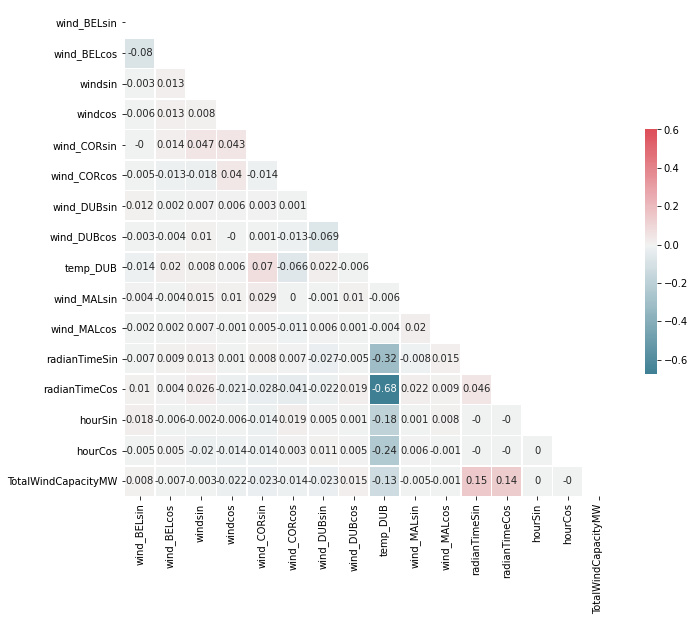

In [21]:
num_df = dataSet.loc[:, attr_2D_wind_time].select_dtypes(['int', 'float'])
# Compute the correlation matrix
corr = num_df.corr()
corr = np.round(corr, 3)
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.6, center=0, annot= True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [22]:
num_df = add_constant(num_df)

vif = [variance_inflation_factor(num_df.to_numpy(), i) for i in range(num_df.to_numpy().shape[1])]

pd.DataFrame(num_df.iloc[:, 1:].columns, vif[1:])

,0
1.007321,wind_BELsin
1.008710,wind_BELcos
1.005459,windsin
1.005148,windcos
1.012793,wind_CORsin
1.025035,wind_CORcos
1.006641,wind_DUBsin
1.005751,wind_DUBcos
2.773041,temp_DUB
1.002443,wind_MALsin


# Training, Validation & Test set

In [23]:
dataSet.shape

(32808, 51)

In [24]:
dataSet.columns

Index(['date', 'hour', 'month', 'year', 'Day_inYear', 'wdsp_BEL', 'wddir_BEL',
       'wind_BELsin', 'wind_BELcos', 'vappr_BEL', 'rhum_BEL', 'temp_BEL',
       'wdsp', 'wddir', 'windsin', 'windcos', 'vappr', 'rhum', 'temp', 'msl',
       'wdsp_COR', 'wddir_COR', 'wind_CORsin', 'wind_CORcos', 'vappr_COR',
       'rhum_COR', 'temp_COR', 'wdsp_DUB', 'wddir_DUB', 'wind_DUBsin',
       'wind_DUBcos', 'vappr_DUB', 'rhum_DUB', 'temp_DUB', 'wdsp_MAL',
       'wddir_MAL', 'wind_MALsin', 'wind_MALcos', 'vappr_MAL', 'rhum_MAL',
       'temp_MAL', 'TotalWindCapacityMW', 'radianTimeSin', 'radianTimeCos',
       'hourSin', 'hourCos', 'ActualWindMW', 'ActualDemandMW', 'ForecastWndMW',
       'ActualWindMW_shift', 'ActualDemandMW_shift'],
      dtype='object')

In [25]:
from sklearn.model_selection import train_test_split
import numpy as np

splitOption = 1

testSet = dataSet.loc[(inData.date > cutOffTestDate), :]
mainSet = dataSet.loc[(inData.date <= cutOffTestDate), :]

if (splitOption == 0): # ---------- Split 0: Completely random ---------------
  trainSet, validSet = train_test_split(mainSet, test_size=0.2, random_state=42)

elif (splitOption == 1):   # ---------- Split 1: Split per day of the month --------------- 
  dataSet["dayInMonth"] = 0

  def setDayInMonth(row):
      row["dayInMonth"] = row.date.day
      return row

  dataSet = dataSet.apply(setDayInMonth, axis=1)

  trainSet = dataSet.loc[(dataSet.dayInMonth < 24), :]
  validSet = dataSet.loc[(dataSet.dayInMonth > 24), :]

elif (splitOption == 2):   # ---------- Split 2: Split randomly on months ---------------
  monthYear = []
  for y in range(2017,2021):
    for m in range(1,13):
      monthYear.append(y*100+m)
  for m in range(1,3): # add the extra months for 2021
    monthYear.append(2021*100+m)
  trainDate, validDate = train_test_split(monthYear, test_size=0.3, random_state=42)

  trainDate = np.array(trainDate)
  validDate = np.array(validDate)

  dataSet['monthYear'] = dataSet.year * 100 + dataSet.month
  dataSet['isTrain'] = 0
  def isTrainData(row, trainDate):
    if (row['monthYear'] in trainDate):
      return 1
    else:
      return 0

  dataSet['isTrain'] = dataSet.apply(lambda row: isTrainData(row, trainDate), axis=1)

  trainSet = dataSet.loc[dataSet.isTrain == 1, :]
  validSet = dataSet.loc[dataSet.isTrain == 0, :]

else:  # ---------- Split 3: Split on a certain month ---------------
  monthYear = []
  for y in range(2017,2021):
    for m in range(1,13):
      monthYear.append(y*100+m)
  for m in range(1,3): # add the extra months for 2021
    monthYear.append(2021*100+m)
  dataSet['monthYear'] = dataSet.year * 100 + dataSet.month

  split_date = 2020 * 100 + 7 # 2020/7
  trainSet = dataSet.loc[dataSet.monthYear <= split_date, :]
  validSet = dataSet.loc[dataSet.monthYear > split_date, :]


y_train = trainSet.ActualWindMW
y_valid = validSet.ActualWindMW
y_test = testSet.ActualWindMW

In [26]:
trainSet.shape, validSet.shape, testSet.shape

((24816, 52), (6912, 52), (359, 51))

In [27]:
trainSet.dtypes

date                    datetime64[ns]
hour                           float64
month                          float64
year                           float64
Day_inYear                       int64
wdsp_BEL                         int64
wddir_BEL                        int64
wind_BELsin                    float64
wind_BELcos                    float64
vappr_BEL                      float64
rhum_BEL                         int64
temp_BEL                       float64
wdsp                             int64
wddir                            int64
windsin                        float64
windcos                        float64
vappr                          float64
rhum                             int64
temp                           float64
msl                            float64
wdsp_COR                         int64
wddir_COR                        int64
wind_CORsin                    float64
wind_CORcos                    float64
vappr_COR                      float64
rhum_COR                 

# Models

## ANN model

### Set up model for each feature set

In [28]:
import tensorflow as tf
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import matplotlib.pyplot as plt

# tf.config.list_physical_devices("GPU")
print(tf.test.gpu_device_name())

tf.random.set_seed(42)

# Callback function to stop the training when no further performance gain
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=3)

/device:GPU:0


### Preprocessing

Scaling the training and validation data using `StandardScaler` (gave better results)

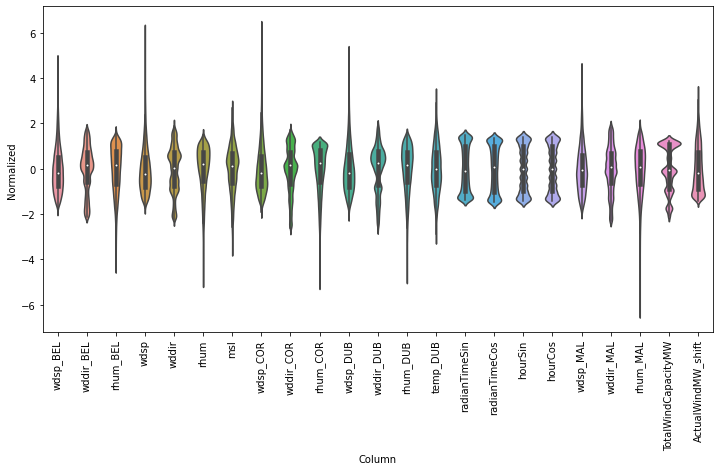

In [29]:
attr_set = {}
ct_set = {}
train_set = {}
valid_set = {}
test_set = {}

for i in range(0,len(attrSet_names)):
    X_train = trainSet.loc[:, attr_selections[i]]
    X_valid = validSet.loc[:, attr_selections[i]]
    X_test = testSet.loc[:, attr_selections[i]]

    ct = make_column_transformer((StandardScaler(), attr_selections[i]))
    ct.fit(X_train)  

    attr_set[attrSet_names[i]] = attr_selections[i]
    ct_set[attrSet_names[i]] = ct
    train_set[attrSet_names[i]] = X_train
    valid_set[attrSet_names[i]] = X_valid
    test_set[attrSet_names[i]] = X_test

    # Visual features validation
    df = dataSet.loc[:, attr_selections[i]]

    df_std = pd.DataFrame(ct.transform(df))
    df_std = df_std.melt(var_name='Column', value_name='Normalized')
    plt.figure(figsize=(12, 6))
    ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
    _ = ax.set_xticklabels(df.keys(), rotation=90)

In [30]:
attrSet_names

['time & rhum & prev actual']

### Model fitting

In [31]:
# saving the feature_sets, models, column_transformer, evaluation history & validation set
eval_hist = {}
models = {}

# train the model for each feature set

for i in attrSet_names:

  ann = tf.keras.models.Sequential([            
            tf.keras.layers.Dense(units=120, activation='relu', name="Layer_1"),
            tf.keras.layers.Dropout(0.1), #drop-out layer to avoid overfit
            tf.keras.layers.Dense(units=120, activation='relu', name="Layer_2"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(units=120, activation='relu', name="Layer_3"),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(units=10, activation='relu', name="Layer_4"),
            tf.keras.layers.Dense(units=1, name="output_layer")
            ])

  ann.compile(loss=tf.keras.losses.mae, # mae is short for mean absolute error
              optimizer=tf.keras.optimizers.Adam(lr=0.002),
              metrics=["mae"])
  
  X_train = train_set[i]
  X_valid = valid_set[i]
  ct = ct_set[i]
  
  X_train_normal = ct.transform(X_train)
  X_valid_normal = ct.transform(X_valid)

  print('------------------------------------------------------------ ' + i + ' ---------------------------------------------------------------------------')
  with tf.device('/device:GPU:0'):
    history = ann.fit(X_train_normal, y_train, epochs = 30, validation_data=(X_valid_normal,y_valid), verbose=0)
    # history = ann.fit(X_train_normal, y_train, epochs = 20, validation_data=(X_valid_normal,y_valid), callbacks=[es])

  eval_hist[i] = history
  models[i] = ann

------------------------------------------------------------ time & rhum & prev actual ---------------------------------------------------------------------------


In [32]:
# Plot model for RadianTime subset (14 features)
from tensorflow.python.keras.utils.vis_utils import plot_model

#plot_model(models['basic'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)

### Plot the learning curve for each ANN model

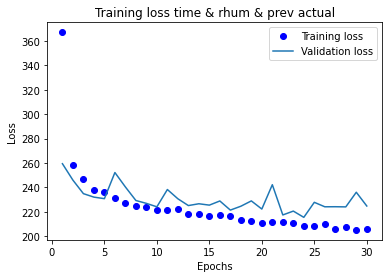

In [33]:
for attr in eval_hist.keys():
  loss = eval_hist[attr].history['loss']
  val_loss = eval_hist[attr].history['val_loss']

  epochs = range(1,len(loss)+1)

  plt.plot(epochs,loss,'bo',label='Training loss')
  plt.plot(epochs,val_loss, label='Validation loss')
  plt.title('Training loss ' + attr)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [34]:
import plotly.express as px

hist = pd.DataFrame(columns=['Traning_MAE', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['Traning_MAE', 'epoch', 'model'])
  temp['Traning_MAE'] = eval_hist[attr].history['loss']
  temp['epoch'] = np.arange(1,len(temp.Traning_MAE)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="Traning_MAE", color='model', width=800, height=400, range_y=[150, 520])
fig.show()

In [35]:
eval_hist

{'time & rhum & prev actual': <tensorflow.python.keras.callbacks.History at 0x7fae0821d850>}

In [36]:
hist = pd.DataFrame(columns=['Validation_MAE', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['Validation_MAE', 'epoch', 'model'])
  temp['Validation_MAE'] = eval_hist[attr].history['val_loss']
  temp['epoch'] = np.arange(1,len(temp.Validation_MAE)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="Validation_MAE", color='model', width=800, height=400, range_y=[150, 520])
fig.show()

### Evaluation metric for each model

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score 

for i in models.keys():
  ann = models[i]
  X_valid = valid_set[i]
  ct = ct_set[i]
  
  X_valid_normal = ct.transform(X_valid)
  preds = ann.predict(X_valid_normal)

  print('--------------------------------------- ' + i + ' -------------------------------------------')
  df_results['ANN Hour', i] = ['ANN Hour', i, 
                               mean_absolute_error(y_valid, preds), 
                               np.sqrt(mean_squared_error(y_valid, preds)), 
                               explained_variance_score(y_valid, preds),
                               'N/A', 'N/A', 'N/A']

  print('MAE:', mean_absolute_error(y_valid, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_valid, preds))) 
  print('Test r2_score:', r2_score(y_valid, preds))

df_results

--------------------------------------- time & rhum & prev actual -------------------------------------------
MAE: 224.78377067821998
RMSE: 301.41043539753775
Test r2_score: 0.9020129505084094


,"(ANN Hour, time & rhum & prev actual)"
attrSet,ANN Hour
algorithm,time & rhum & prev actual
Valid MAE,224.784
Valid RMSE,301.41
Valid explained_variance_score,0.907884
Test MAE,N/A
Test RMSE,N/A
Test explained_variance_score,N/A


In [38]:
for i in models.keys():
  ann = models[i]
  X_test = test_set[i]
  ct = ct_set[i]
  
  X_test_normal = ct.transform(X_test)
  preds = ann.predict(X_test_normal)

  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_test, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_test, preds))) 
  print('Test r2_score:', r2_score(y_test, preds))

--------------------------------------- time & rhum & prev actual -------------------------------------------
MAE: 243.52679664378047
RMSE: 319.3372865432104
Test r2_score: 0.9272143615952315


In [39]:
print('Eirgrid forecast MAE:', mean_absolute_error(testSet['ActualWindMW'], testSet['ForecastWndMW']))

Eirgrid forecast MAE: 345.65947075208913


### Testing the models with 2021 data

#### Test data preparation

#### Evaluation the predictions for testing data

In [40]:
from plotly.offline import iplot
import plotly.graph_objs as go
from plotly import tools
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

In [41]:
for i in models.keys():
  ann = models[i]

  X_test = test_set[i]
  ct = ct_set[i]
  X_test_normal = ct.transform(X_test)

  preds = ann.predict(X_test_normal)
  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_test, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_test, preds))) 
  print('Test r2_score:', r2_score(y_test, preds))

  df_results['ANN Hour', i]['Test MAE'] = mean_absolute_error(y_test, preds)
  df_results['ANN Hour', i]['Test RMSE'] = np.sqrt(mean_squared_error(y_test, preds))
  df_results['ANN Hour', i]['Test explained_variance_score'] = explained_variance_score(y_test, preds)
  
  predsds = pd.DataFrame(preds)

  fig = make_subplots(
      rows=1, cols=1,
      specs=[[{"secondary_y": True}]],
      subplot_titles=("Wind"))


  fig.add_trace(go.Scatter(x=testSet['date'], y=testSet['ForecastWndMW'],
                      mode='lines',
                      name='Eirgrid Forecast Wnd',showlegend=True), 1, 1, secondary_y=False)

 
  fig.add_trace(go.Scatter(x=testSet['date'], y=(0.7*testSet['ActualDemandMW']),
                         line=dict(color='firebrick', width=1, dash='dash'), # dash options include 'dash', 'dot', and 'dashdot'
                         name='70% Actual Demand',showlegend=True), 1, 1, secondary_y=False)
  
  fig.add_trace(go.Scatter(x=testSet['date'], y=testSet['ActualWindMW'],
                      mode='lines',
                      name='Wind Actual',showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=testSet['date'], y=predsds[0],
                      mode='lines',
                      name=(i + ' Dataset Predictions'),showlegend=True), 1, 1, secondary_y=False)


  fig.update_layout(
      title_text="Wind actual vs. Predictions for last weeks of March 2021 (hourly model)",
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showgrid=False,
          zeroline=False,
          showline=False,
          showticklabels=True,
      ),
      autosize=False,
      margin=dict(
          l=100,
          r=20,
          t=110,
      ),
      plot_bgcolor='white',
      width=1400,
      height=500
  )
  fig.show()

--------------------------------------- time & rhum & prev actual -------------------------------------------
MAE: 243.52679664378047
RMSE: 319.3372865432104
Test r2_score: 0.9272143615952315


In [42]:
df_results

,"(ANN Hour, time & rhum & prev actual)"
attrSet,ANN Hour
algorithm,time & rhum & prev actual
Valid MAE,224.784
Valid RMSE,301.41
Valid explained_variance_score,0.907884
Test MAE,243.527
Test RMSE,319.337
Test explained_variance_score,0.945924


# 24h window

## Util for transforming into 24 hours windos to predict 24h in 1 go

In [43]:
HOURS_AHEAD = 24



In [44]:
def window_split_transform(data, timesteps, listCols):
  n = np.floor_divide(data.shape[0], timesteps)

  t = np.zeros((n, timesteps, len(listCols)))
  for i in range(n):
    currLoc = i*timesteps
    t[i] = data.iloc[currLoc:(currLoc+timesteps)][listCols]  

  return t

In [45]:
def window_split_target(data, timesteps, targetCol):
  n = np.floor_divide(data.shape[0], timesteps)

  t = np.zeros((n, timesteps))
  for i in range(n):
    currLoc = i*timesteps
    if (target_cols == ""):
      t[i] = data.iloc[currLoc:(currLoc+timesteps)]
    else:
      t[i] = data.iloc[currLoc:(currLoc+timesteps)][targetCol]
  return t

In [46]:
def window_split_series(data, timesteps):
  n = np.floor_divide(data.shape[0], timesteps)

  t = np.zeros((n, timesteps))
  for i in range(n):
    currLoc = i*timesteps
    t[i] = data.iloc[currLoc:(currLoc+timesteps)]
  return t

## Different feature set

In [47]:
import tensorflow as tf
from tensorflow.keras import layers

# saving the feature_sets, models, column_transformer, evaluation history & validation set
eval_hist = {}
models = {}

# train the model for each feature set

for i in attrSet_names:

  s = len(train_set[i].columns)
  print("Feature set: "+ str(i) + " Features num: " + str(s))

  modelDay = tf.keras.Sequential()
  modelDay.add(layers.Dense(s, activation=tf.nn.relu, input_shape=(HOURS_AHEAD, s)))
  modelDay.add(layers.Dense(s, activation=tf.nn.relu))
  modelDay.add(layers.Dense(s, activation=tf.nn.relu))
  modelDay.add(layers.Dense(s, activation=tf.nn.relu))
  modelDay.add(layers.Dense(s, activation=tf.nn.relu))
  modelDay.add(layers.Flatten())
  modelDay.add(layers.Dense(len(attr_basic)*HOURS_AHEAD//2, activation=tf.nn.relu))
  modelDay.add(layers.Dense(HOURS_AHEAD))

  nadam = tf.keras.optimizers.Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
  modelDay.compile(optimizer=nadam, loss=tf.losses.MeanSquaredError())
  
  X_train = train_set[i]
  X_valid = valid_set[i]
  ct = ct_set[i]
  
  X_train_normal = pd.DataFrame(ct.transform(X_train), columns=X_train.columns)
  X_valid_normal = pd.DataFrame(ct.transform(X_valid), columns=X_valid.columns)

  X_train_normalWnd = window_split_transform(X_train_normal, HOURS_AHEAD, X_train.columns)
  y_trainWnd = window_split_series(y_train, HOURS_AHEAD)

  X_valid_normalWnd = window_split_transform(X_valid_normal, HOURS_AHEAD, X_train.columns)
  y_validWnd = window_split_series(y_valid, HOURS_AHEAD)
 
  print('------------------------------------------------------------ ' + i + ' ---------------------------------------------------------------------------')
  with tf.device('/device:GPU:0'):
    history = modelDay.fit(X_train_normalWnd, y_trainWnd, epochs = 160, validation_data=(X_valid_normalWnd,y_validWnd), verbose=0)
    # history = ann.fit(X_train_normal, y_train, epochs = 20, validation_data=(X_valid_normal,y_valid), callbacks=[es])

  eval_hist[i] = history
  models[i] = modelDay

Feature set: time & rhum & prev actual Features num: 23
------------------------------------------------------------ time & rhum & prev actual ---------------------------------------------------------------------------


In [48]:
from tensorflow.python.keras.utils.vis_utils import plot_model

#plot_model(models['basic'], to_file='model_plot.png', show_shapes=True, show_layer_names=True)


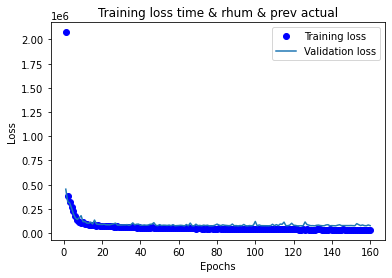

In [49]:
for attr in eval_hist.keys():
  loss = eval_hist[attr].history['loss']
  val_loss = eval_hist[attr].history['val_loss']

  epochs = range(1,len(loss)+1)

  plt.plot(epochs,loss,'bo',label='Training loss')
  plt.plot(epochs,val_loss, label='Validation loss')
  plt.title('Training loss ' + attr)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

In [50]:
import plotly.express as px

hist = pd.DataFrame(columns=['Traning_MAE', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['Traning_MAE', 'epoch', 'model'])
  temp['Traning_MAE'] = eval_hist[attr].history['loss']
  temp['epoch'] = np.arange(1,len(temp.Traning_MAE)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="Traning_MAE", color='model', width=800, height=400, range_y=[10000, 520000])
fig.show()

In [51]:
hist = pd.DataFrame(columns=['Validation_MAE', 'epoch', 'model']);
for attr in eval_hist.keys():
  temp = pd.DataFrame(columns=['Validation_MAE', 'epoch', 'model'])
  temp['Validation_MAE'] = eval_hist[attr].history['val_loss']
  temp['epoch'] = np.arange(1,len(temp.Validation_MAE)+1)
  temp['model'] = attr
  hist = pd.concat([hist, temp],ignore_index=True)

fig = px.line(hist, x="epoch", y="Validation_MAE", color='model', width=800, height=400, range_y=[10000, 520000])
fig.show()

In [52]:
X_valid.columns

Index(['wdsp_BEL', 'wddir_BEL', 'rhum_BEL', 'wdsp', 'wddir', 'rhum', 'msl',
       'wdsp_COR', 'wddir_COR', 'rhum_COR', 'wdsp_DUB', 'wddir_DUB',
       'rhum_DUB', 'temp_DUB', 'radianTimeSin', 'radianTimeCos', 'hourSin',
       'hourCos', 'wdsp_MAL', 'wddir_MAL', 'rhum_MAL', 'TotalWindCapacityMW',
       'ActualWindMW_shift'],
      dtype='object')

--------------------------------------- time & rhum & prev actual -------------------------------------------
MAE: 204.1194450038149
RMSE: 277.5227325296522
Test r2_score: 0.9141986650535724
             error
count  6912.000000
mean     22.238669
std     276.650287
min   -2178.510254
25%    -136.719749
50%      20.771122
75%     172.700378
max    2204.955566


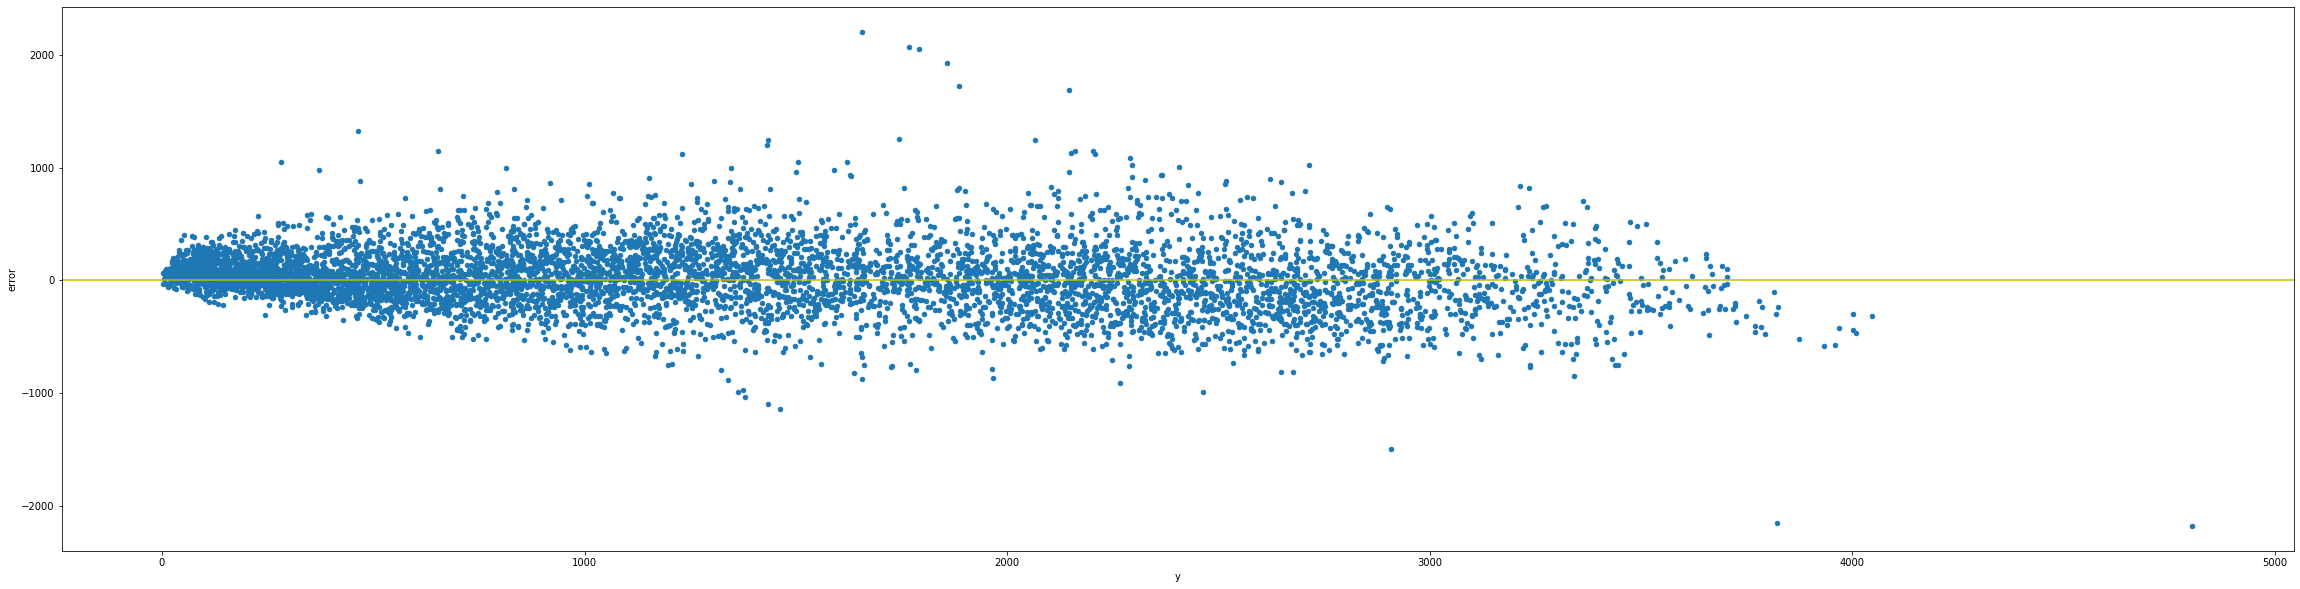

In [53]:
# Validation error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


for i in models.keys():
  ann = models[i]
  X_valid = valid_set[i]
  ct = ct_set[i]
  
  X_valid_normal = pd.DataFrame(ct.transform(X_valid), columns=X_valid.columns)
  X_valid_normalWnd = window_split_transform(X_valid_normal, HOURS_AHEAD, X_valid.columns)
  y_validWnd = window_split_series(y_valid, HOURS_AHEAD)

  preds = ann.predict(X_valid_normalWnd)

  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_validWnd, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_validWnd, preds))) 
  print('Test r2_score:', r2_score(y_validWnd, preds))
  df_results['ANN 24Hour', i] = ['ANN 24Hour', i, 
                               mean_absolute_error(y_validWnd, preds), 
                               np.sqrt(mean_squared_error(y_validWnd, preds)), 
                               explained_variance_score(y_validWnd, preds),
                               'N/A', 'N/A', 'N/A']

  #testSetCopy = dataSet.iloc[testStart*HOURS_AHEAD:((testStart+len(y_test))*HOURS_AHEAD)].copy()
  preds_flattened = preds.reshape(1, -1)[0]
  y_valid_flattened = y_validWnd.reshape(1, -1)[0]
  testSetCopy = validSet.head(len(preds_flattened)).copy()
  testSetCopy['predicted_WindMW'] = preds.reshape(1, -1)[0]

  # Plot validation set error
  testSetCopy['error']= preds.reshape(1, -1)[0] - y_valid
  testSetCopy['y']= y_valid

  testSetCopy.plot.scatter(x='y', y='error', figsize=(40, 10))
  plt.axhline(y=0, color='y', label="0")

  print(testSetCopy[['error']].describe())


In [54]:
testSetCopy[['error']].describe()

,error
count,6912.000000
mean,22.238669
std,276.650287
min,-2178.510254
25%,-136.719749
50%,20.771122
75%,172.700378
max,2204.955566


In [55]:
df_results

,"(ANN Hour, time & rhum & prev actual)","(ANN 24Hour, time & rhum & prev actual)"
attrSet,ANN Hour,ANN 24Hour
algorithm,time & rhum & prev actual,time & rhum & prev actual
Valid MAE,224.784,204.119
Valid RMSE,301.41,277.523
Valid explained_variance_score,0.907884,0.915035
Test MAE,243.527,N/A
Test RMSE,319.337,N/A
Test explained_variance_score,0.945924,N/A


In [56]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

for i in models.keys():
  ann = models[i]
  X_test = test_set[i]
  ct = ct_set[i]
  
  X_test_normal = pd.DataFrame(ct.transform(X_test), columns=X_test.columns)
  X_test_normalWnd = window_split_transform(X_test_normal, HOURS_AHEAD, X_test.columns)
  y_testWnd = window_split_series(y_test, HOURS_AHEAD)

  preds = ann.predict(X_test_normalWnd)

  print('--------------------------------------- ' + i + ' -------------------------------------------')
  print('MAE:', mean_absolute_error(y_testWnd, preds))
  #print('mean_absolute_percentage_error: ', mean_absolute_percentage_error(y_valid, preds))
  print('RMSE:', np.sqrt(mean_squared_error(y_testWnd, preds))) 
  print('Test r2_score:', r2_score(y_testWnd, preds))

  df_results['ANN 24Hour', i]['Test MAE'] = mean_absolute_error(y_testWnd, preds ) 
  df_results['ANN 24Hour', i]['Test RMSE'] = np.sqrt(mean_squared_error(y_testWnd, preds)) 
  df_results['ANN 24Hour', i]['Test explained_variance_score'] = explained_variance_score(y_testWnd, preds)

  #testSetCopy = dataSet.iloc[testStart*HOURS_AHEAD:((testStart+len(y_test))*HOURS_AHEAD)].copy()
  preds_flattened = preds.reshape(1, -1)[0]
  testSetCopy = testSet.head(len(preds_flattened)).copy()
  testSetCopy['predicted_WindMW'] = preds.reshape(1, -1)[0]

  print('Eirgrid forecast MAE:', mean_absolute_error(testSetCopy['ActualWindMW'], testSetCopy['ForecastWndMW']))



  fig = make_subplots(
      rows=1, cols=1,
      specs=[[{"secondary_y": True}]],
      subplot_titles=("Wind"))


  fig.add_trace(go.Scatter(x=testSetCopy['date'], y=testSetCopy['ForecastWndMW'],
                      mode='lines',
                      name='Eirgrid Forecast Wnd',showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=testSetCopy['date'], y=(0.7*testSetCopy['ActualDemandMW']),
                         line=dict(color='firebrick', width=1, dash='dash'), # dash options include 'dash', 'dot', and 'dashdot'
                         name='70% Actual Demand',showlegend=True), 1, 1, secondary_y=False)
  
  fig.add_trace(go.Scatter(x=testSetCopy['date'], y=testSetCopy['ActualWindMW'],
                      mode='lines',
                      name='Wind Actual',showlegend=True), 1, 1, secondary_y=False)

  fig.add_trace(go.Scatter(x=testSetCopy['date'], y=testSetCopy['predicted_WindMW'],
                      mode='lines',
                      name=('24h Dataset Predictions'),showlegend=True), 1, 1, secondary_y=False)


  fig.update_layout(
      title_text="Wind actual vs. Predictions for last weeks of March 2021 (24-hour model)",
      xaxis=dict(
          showline=True,
          showgrid=False,
          showticklabels=True,
          linecolor='rgb(204, 204, 204)',
          linewidth=2,
          ticks='outside',
          tickfont=dict(
              family='Arial',
              size=12,
              color='rgb(82, 82, 82)',
          ),
      ),
      yaxis=dict(
          showgrid=False,
          zeroline=False,
          showline=False,
          showticklabels=True,
      ),
      autosize=False,
      margin=dict(
          l=100,
          r=20,
          t=110,
      ),
      plot_bgcolor='white',
      width=1400,
      height=800
  )
  fig.show()

--------------------------------------- time & rhum & prev actual -------------------------------------------
MAE: 166.84482251462484
RMSE: 219.48126721018602
Test r2_score: 0.9532097970627763
Eirgrid forecast MAE: 315.7708333333333


In [57]:
df_results

,"(ANN Hour, time & rhum & prev actual)","(ANN 24Hour, time & rhum & prev actual)"
attrSet,ANN Hour,ANN 24Hour
algorithm,time & rhum & prev actual,time & rhum & prev actual
Valid MAE,224.784,204.119
Valid RMSE,301.41,277.523
Valid explained_variance_score,0.907884,0.915035
Test MAE,243.527,166.845
Test RMSE,319.337,219.481
Test explained_variance_score,0.945924,0.96123


# Predictions

In [169]:
#attr_selections = [attr_basic, attr_shifted, attr_2D_wind_time, attr_rhum_time, attr_rhum_time_shift]
#attrSet_names = ['basic', 'basic & prev actual', 'wind & time', 'time & rhum', 'time & rhum & prev actual']

attr_selection = attr_rhum_time_shift
attrSetName = 'time & rhum & prev actual'

#attr_selection = attr_rhum_time
#attrSetName = 'time & rhum'

## Met Éireann Weather Forecast API
Published by: Met Éireann
 32 
Licensed under: Met Eireann Custom Open Data Licence
https://data.gov.ie/dataset/met-eireann-weather-forecast-api/resource/027da6d5-d819-48d1-9b16-331dba169bd1

In [170]:
from xml.dom.minidom import parse
import xml.dom.minidom
import io
import requests

In [171]:
def getWeather(lat, long, name):

    url = "http://metwdb-openaccess.ichec.ie/metno-wdb2ts/locationforecast?lat={};long={}".format(lat, long)
    s = requests.get(url).content

    DOMTree = xml.dom.minidom.parse(io.StringIO(s.decode('utf-8')))

    collection = DOMTree.documentElement
    if collection.hasAttribute("shelf"):
       print ("Root element : ", collection.getAttribute("shelf"))

    # Get all the movies in the collection
    product = collection.getElementsByTagName("product")

    df_cols = ['date', 'wddir', 'wdsp', 'temp', 'msl', 'rhum']
    rows = []

    product = collection.getElementsByTagName("product")
    timefcs = collection.getElementsByTagName("time")


    # Print detail of each movie.
    for timefc in timefcs:
        if timefc.hasAttribute("from"):
            fromtime =""
            wdeg = None
            wsp = None
            temp = None
            msl = None
            rhum = None

            #print ("from: ", timefc.getAttribute("from"))
            fromtime = timefc.getAttribute("from")

            location = timefc.getElementsByTagName('location')[0]

            if (len(location.getElementsByTagName('windDirection')) > 0 ):
                wd = location.getElementsByTagName('windDirection')[0]
                if wd.hasAttribute("deg"):
                    wdeg = float(wd.getAttribute("deg"))
                    #print ("Wi)nd Direction deg: ", wd.getAttribute("deg"))    

            if (len(location.getElementsByTagName('windSpeed')) > 0):
                wsp = location.getElementsByTagName('windSpeed')[0]
                if wsp.hasAttribute("mps"):
                    wsp = float(wsp.getAttribute("mps"))

            if (len(location.getElementsByTagName('pressure')) > 0):
                msl = location.getElementsByTagName('pressure')[0]
                if msl.hasAttribute("value"):
                    msl = float(msl.getAttribute("value"))

            if (len(location.getElementsByTagName('humidity')) > 0):
                rhum = location.getElementsByTagName('humidity')[0]
                if rhum.hasAttribute("value"):
                    rhum = float(rhum.getAttribute("value"))

            if (len(location.getElementsByTagName('temperature')) > 0):
                temp = location.getElementsByTagName('temperature')[0]
                if temp.hasAttribute("value"):
                    temp = float(temp.getAttribute("value"))
        #print ("From: " + fromtime + " Wind Direction deg: " + str(wdeg) + " Wind Speed mps: " + str(wsp))    
        if (wdeg != None):
            rows.append({"date": fromtime, "wddir": wdeg, "wdsp": wsp, "temp": temp, "msl": msl, "rhum": rhum})


    # <windDirection id="dd" deg="348.0" name="N"/>
    # <windSpeed id="ff" mps="3.2" beaufort="2" name="Svak vind"/>


    out_df = pd.DataFrame(rows, columns = df_cols)
    
    out_df["date"] = pd.to_datetime(out_df["date"], infer_datetime_format=True, errors='ignore')

    #out_df.to_csv(name + "weather.csv")

    return out_df

In [172]:
# Belmullet: 54.225, -9.991
lat=54.225
long=-9.991

BELMULLETds = getWeather(lat, long, "Belmullet")

In [173]:
# Cork Airport: 51.8382 Longitude: -8.4880
lat= 51.8382
long= -8.4880

corkairportds = getWeather(lat, long, "Cork")

In [174]:
# Shannon Airport, Ireland. Latitude: 52.7012 Longitude: -8.9215.
lat= 52.7012
long= -8.9215

shannonairportds = getWeather(lat, long, "Shannon")

In [175]:
# Dublin Airport in Ireland. Latitude: 53.4264 Longitude: -6.2499
lat= 53.4264
long= -6.2499

dublinairportds = getWeather(lat, long, "Dublin")

In [176]:
# Malin Head:  55.3833318 -7.3666652
lat=55.3833318
long=-7.3666652

MALds = getWeather(lat, long, "Malin Head")

In [177]:
left = BELMULLETds.set_index(['date']).copy()
right = dublinairportds.set_index(['date'])
#right.index = right.index.tz_convert(None)

wfds = left.join(right, lsuffix="_BEL", rsuffix="_DUB")

right = shannonairportds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_SHA")

right = corkairportds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_COR")

right = MALds.set_index(['date'])
wfds = wfds.join(right, lsuffix="", rsuffix="_MAL")

wfds = wfds.reset_index()


In [178]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Met Station"))


fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_BEL'],
                    mode='lines',
                    name='Belmullet Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_COR'],
                    mode='lines',
                    name='Cork Airport Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp'],
                    mode='lines',
                    name='Shannon Airport Wind Speed',showlegend=True), 1, 1, secondary_y=False)
fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_DUB'],
                    mode='lines',
                    name='Dublin Airport Wind Speed',showlegend=True), 1, 1, secondary_y=False)
fig.add_trace(go.Scatter(x=wfds['date'], y=wfds['wdsp_MAL'],
                    mode='lines',
                    name='Malin head Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.update_layout(
    title_text="Wind speed ",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=1400,
    height=500
)
fig.show()

In [179]:
# Weather Hourly data wind speed in knt, for some reason, 1 knt = 0.514 m/s
knot = 0.514
wfds.wdsp_BEL = wfds.wdsp_BEL / knot
wfds.wdsp = wfds.wdsp / knot
wfds.wdsp_COR = wfds.wdsp_COR / knot
wfds.wdsp_DUB = wfds.wdsp_DUB / knot
wfds.wdsp_MAL = wfds.wdsp_MAL / knot

In [180]:
fig = go.Figure()
fig.add_trace(go.Box(y=dataSet['wdsp_BEL'], name='BEL'))
fig.add_trace(go.Box(y=wfds['wdsp_BEL'], name='BEL forecast'))
fig.add_trace(go.Box(y=dataSet['wdsp_DUB'], name = 'DUB'))
fig.add_trace(go.Box(y=wfds['wdsp_DUB'], name='DUB forecast'))
fig.add_trace(go.Box(y=dataSet['wdsp'], name = 'SHA'))
fig.add_trace(go.Box(y=wfds['wdsp'], name='SHA forecast'))

fig.add_trace(go.Box(y=dataSet['wdsp_COR'], name = 'CORK'))
fig.add_trace(go.Box(y=wfds['wdsp_COR'], name='CORK forecast'))

fig.add_trace(go.Box(y=dataSet['wdsp_MAL'], name = 'MALIN Head'))
fig.add_trace(go.Box(y=wfds['wdsp_MAL'], name='Malin forecast'))
fig.show()

## Run transforms

In [181]:
wfds.columns


Index(['date', 'wddir_BEL', 'wdsp_BEL', 'temp_BEL', 'msl_BEL', 'rhum_BEL',
       'wddir_DUB', 'wdsp_DUB', 'temp_DUB', 'msl_DUB', 'rhum_DUB', 'wddir',
       'wdsp', 'temp', 'msl', 'rhum', 'wddir_COR', 'wdsp_COR', 'temp_COR',
       'msl_COR', 'rhum_COR', 'wddir_MAL', 'wdsp_MAL', 'temp_MAL', 'msl_MAL',
       'rhum_MAL'],
      dtype='object')

In [182]:
wfds['TotalWindCapacityMW'] = dataSet['TotalWindCapacityMW'].max()

wfds["hour"] = 0
wfds["isweekday"] = False
wfds["month"] = 0
wfds['year'] = 0
wfds["day"] = 0
def settimeattfull(row):
    row["hour"] = row.date.hour
    row["isweekday"] = (row.date.isoweekday() < 6) 
    row["month"] = row.date.month
    row["year"] = row.date.year
    row["day"] = row.date.day
    return row

wfds = wfds.apply(settimeattfull, axis='columns')

In [183]:
wfds = transformTimeInto2d(wfds)
wfds.columns

Index(['date', 'wddir_BEL', 'wdsp_BEL', 'temp_BEL', 'msl_BEL', 'rhum_BEL',
       'wddir_DUB', 'wdsp_DUB', 'temp_DUB', 'msl_DUB', 'rhum_DUB', 'wddir',
       'wdsp', 'temp', 'msl', 'rhum', 'wddir_COR', 'wdsp_COR', 'temp_COR',
       'msl_COR', 'rhum_COR', 'wddir_MAL', 'wdsp_MAL', 'temp_MAL', 'msl_MAL',
       'rhum_MAL', 'TotalWindCapacityMW', 'hour', 'isweekday', 'month', 'year',
       'day', 'Day_inYear', 'daysInYear', 'radianTime', 'radianTimeCos',
       'radianTimeSin', 'hourCos', 'hourSin'],
      dtype='object')

## Eirgrid data

In [184]:
def getCurrentEirgridWindPrediction(): 
  url_base = 'https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom='
  url_mid = '%2000:00&dateto='
  url_end = '%2023:59'

  now = datetime.now()
  yesterday = now - timedelta(days=1)
  tomorrow = now + timedelta(days=1)

  date_time = yesterday.strftime("%d-%b-%Y")
  tom_date_time = tomorrow.strftime("%d-%b-%Y") 
  #print("Date and Time:",date_time)
  url = url_base + date_time + url_mid + tom_date_time + url_end
  print(url)

  s = requests.get(url).content
  mds = pd.read_csv(io.StringIO(s.decode('utf-8')), na_values='-')
  mds['date'] = pd.to_datetime(mds["DATE & TIME"], infer_datetime_format=True, errors='ignore')
  mds = mds.rename(columns={' FORECAST WIND(MW)' : 'ForecastWndMW'})
  #mds = mds.rename(columns={'  ACTUAL WIND(MW)' : 'ActualWindMW'})

  mds["ActualWindMW_shift"] = mds['  ACTUAL WIND(MW)'].shift(4*24)
  mds.drop('DATE & TIME', axis=1, inplace=True)
  mds.drop(' REGION', axis=1, inplace=True)

  return mds


In [185]:
def getCurrentEirgridDemandPrediction(): 
  url_base = 'https://www.smartgriddashboard.com/DashboardService.svc/csv?area=demandActual&region=ALL&datefrom='
  url_mid = '%2000:00&dateto='
  url_end = '%2023:59'

  now = datetime.now()
  yesterday = now - timedelta(days=1)
  tomorrow = now + timedelta(days=1)

  date_time = yesterday.strftime("%d-%b-%Y")
  tom_date_time = tomorrow.strftime("%d-%b-%Y") 
  #print("Date and Time:",date_time)
  url = url_base + date_time + url_mid + tom_date_time + url_end
  print(url)

  s = requests.get(url).content
  mds = pd.read_csv(io.StringIO(s.decode('utf-8')), na_values='-')
  mds['date'] = pd.to_datetime(mds["DATE & TIME"], infer_datetime_format=True, errors='ignore')

  mds = mds.rename(columns={' ACTUAL DEMAND(MW)' : 'ActualDemandMW'})
  mds = mds.rename(columns={' FORECAST DEMAND(MW)' : 'ForecastDemandMW'})
  mds.drop('DATE & TIME', axis=1, inplace=True)
  mds.drop(' REGION', axis=1, inplace=True)

  return mds


In [186]:
"https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=24-May-2021%2000:00&dateto=24-May-2021%2023:59"

'https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=24-May-2021%2000:00&dateto=24-May-2021%2023:59'

In [187]:
eds = getCurrentEirgridDemandPrediction()

left = wfds.set_index(['date'])
right = eds.set_index(['date'])
wfds = left.join(right)

https://www.smartgriddashboard.com/DashboardService.svc/csv?area=demandActual&region=ALL&datefrom=24-May-2021%2000:00&dateto=26-May-2021%2023:59


https://www.smartgriddashboard.com/DashboardService.svc/csv?area=windActual&region=ALL&datefrom=24-May-2021%2000:00&dateto=26-May-2021%2023:59


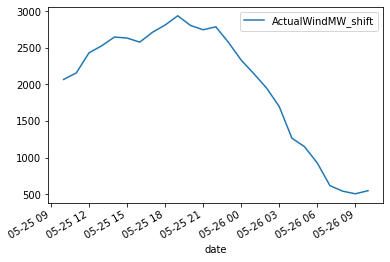

In [188]:
mds = getCurrentEirgridWindPrediction()

right = mds.set_index(['date'])
wfds = wfds.join(right)

wfds.plot( y='ActualWindMW_shift')


In [189]:
wfds = wfds.iloc[0:24]

In [190]:
wfds

,wddir_BEL,wdsp_BEL,temp_BEL,msl_BEL,rhum_BEL,wddir_DUB,wdsp_DUB,temp_DUB,msl_DUB,rhum_DUB,wddir,wdsp,temp,msl,rhum,wddir_COR,wdsp_COR,temp_COR,msl_COR,rhum_COR,wddir_MAL,wdsp_MAL,temp_MAL,msl_MAL,rhum_MAL,TotalWindCapacityMW,hour,isweekday,month,year,day,Day_inYear,daysInYear,radianTime,radianTimeCos,radianTimeSin,hourCos,hourSin,ActualDemandMW,ForecastDemandMW,ForecastWndMW,ACTUAL WIND(MW),ActualWindMW_shift
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-05-25 10:00:00,326.3,9.143969,11.9,1017.7,72.9,286.9,10.311284,14.5,1015.8,55.1,47.7,2.140078,9.9,1018.0,84.5,115.0,4.280156,8.3,1018.0,94.5,336.2,15.564202,10.3,1016.2,73.9,5576.095,10,True,5,2021,25,145,365,2.503233,-0.803074,0.595879,-8.660254e-01,5.000000e-01,5005.0,NaN,558.0,550.0,2069.0
2021-05-25 11:00:00,331.2,8.754864,12.7,1017.9,70.4,292.8,9.727626,15.6,1015.7,50.4,59.9,1.945525,10.9,1017.9,83.7,79.8,5.642023,8.3,1017.5,96.0,335.2,15.564202,10.4,1016.5,73.1,5576.095,11,True,5,2021,25,145,365,2.503950,-0.803501,0.595303,-9.659258e-01,2.588190e-01,NaN,4848.0,550.0,NaN,2158.0
2021-05-25 12:00:00,335.1,7.782101,12.7,1018.2,74.4,289.3,9.338521,15.9,1015.5,49.7,219.3,1.361868,12.1,1017.7,81.4,68.6,5.058366,8.5,1017.4,95.0,331.9,15.758755,10.2,1016.7,72.2,5576.095,12,True,5,2021,25,145,365,2.504667,-0.803928,0.594727,-1.000000e+00,1.224647e-16,NaN,4844.0,528.0,NaN,2432.0
2021-05-25 13:00:00,6.3,8.171206,12.9,1018.2,75.7,291.7,8.754864,15.5,1015.3,50.4,267.1,4.474708,12.5,1017.6,79.9,41.0,4.280156,9.4,1017.4,93.0,327.3,14.785992,10.3,1017.0,73.4,5576.095,13,True,5,2021,25,145,365,2.505384,-0.804354,0.594150,-9.659258e-01,-2.588190e-01,NaN,4848.0,576.0,NaN,2528.0
2021-05-25 14:00:00,4.4,10.311284,12.8,1018.4,70.1,310.6,7.782101,15.9,1015.2,51.7,261.6,5.058366,14.4,1017.4,76.5,14.6,3.112840,10.1,1017.4,90.1,320.7,15.758755,10.3,1017.1,74.2,5576.095,14,True,5,2021,25,145,365,2.506102,-0.804780,0.593573,-8.660254e-01,-5.000000e-01,NaN,4693.0,674.0,NaN,2647.0
2021-05-25 15:00:00,2.5,10.116732,12.6,1018.6,68.4,326.7,8.171206,15.5,1015.1,50.3,249.8,6.614786,14.5,1017.2,70.9,333.1,5.058366,11.4,1017.3,88.6,321.3,15.953307,9.9,1017.2,73.0,5576.095,15,True,5,2021,25,145,365,2.506819,-0.805206,0.592995,-7.071068e-01,-7.071068e-01,NaN,4654.0,760.0,NaN,2634.0
2021-05-25 16:00:00,1.3,10.116732,12.0,1018.5,68.8,323.7,8.949416,15.8,1015.0,49.5,298.7,9.922179,15.2,1016.9,63.7,306.1,6.225681,11.9,1017.1,83.1,319.1,15.953307,9.8,1017.3,70.5,5576.095,16,True,5,2021,25,145,365,2.507536,-0.805631,0.592418,-5.000000e-01,-8.660254e-01,NaN,4758.0,849.0,NaN,2578.0
2021-05-25 17:00:00,358.5,9.338521,11.6,1018.7,68.0,325.3,8.560311,15.5,1015.1,51.0,293.3,9.922179,15.1,1017.1,60.9,304.5,7.003891,12.1,1017.1,79.5,319.2,16.536965,9.6,1017.2,70.8,5576.095,17,True,5,2021,25,145,365,2.508253,-0.806056,0.591840,-2.588190e-01,-9.659258e-01,NaN,4983.0,940.0,NaN,2712.0
2021-05-25 18:00:00,2.2,9.533074,11.1,1019.0,69.4,326.2,8.171206,14.3,1015.6,52.4,296.9,10.116732,14.4,1017.4,65.0,301.5,7.587549,11.9,1017.3,81.3,327.3,16.536965,9.3,1017.3,75.1,5576.095,18,True,5,2021,25,145,365,2.508971,-0.806480,0.591261,-1.836970e-16,-1.000000e+00,NaN,5082.0,993.0,NaN,2811.0


## Predictions

In [191]:
models.keys()

dict_keys(['time & rhum & prev actual'])

In [192]:

for i in models.keys():
  print(i)

time & rhum & prev actual


In [193]:
redtds = wfds.loc[ : , attr_selection]

redtds.columns

Index(['wdsp_BEL', 'wddir_BEL', 'rhum_BEL', 'wdsp', 'wddir', 'rhum', 'msl',
       'wdsp_COR', 'wddir_COR', 'rhum_COR', 'wdsp_DUB', 'wddir_DUB',
       'rhum_DUB', 'temp_DUB', 'radianTimeSin', 'radianTimeCos', 'hourSin',
       'hourCos', 'wdsp_MAL', 'wddir_MAL', 'rhum_MAL', 'TotalWindCapacityMW',
       'ActualWindMW_shift'],
      dtype='object')

In [194]:

i = attrSetName
ann = models[i]
#X_test = test_set[i]
ct = ct_set[i]

X_test_normal = pd.DataFrame(ct.transform(redtds), columns=redtds.columns)
X_test_normalWnd = window_split_transform(X_test_normal, HOURS_AHEAD, redtds.columns)

preds = ann.predict(X_test_normalWnd)

print('--------------------------------------- ' + i + ' -------------------------------------------')
preds_flattened = preds.reshape(1, -1)[0]


#testSetCopy = testSet.head(len(preds_flattened)).copy()
#testSetCopy['predicted_WindMW'] = preds.reshape(1, -1)[0]



--------------------------------------- time & rhum & prev actual -------------------------------------------


In [196]:
# Perform EDA, visualize, etc...
fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"secondary_y": True}]],
    subplot_titles=("Met Station"))


fig.add_trace(go.Scatter(x=wfds.index, y=wfds['wdsp_BEL'],
                    mode='lines',
                    name='Belmullet Wind Speed',showlegend=True), 1, 1, secondary_y=False)


fig.add_trace(go.Scatter(x=wfds.index, y=wfds['wdsp_MAL'],
                    mode='lines',
                    name='Malin Head Wind Speed',showlegend=True), 1, 1, secondary_y=False)

fig.add_trace(go.Scatter(x=wfds.index, y=preds_flattened,
                    mode='lines', 
                    name='Wind Preds',showlegend=True), 1, 1, secondary_y=True)

fig.update_layout(
    title_text="Wind speed ",
    xaxis=dict(
        showline=True,
        showgrid=False,
        showticklabels=True,
        linecolor='rgb(204, 204, 204)',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Arial',
            size=12,
            color='rgb(82, 82, 82)',
        ),
    ),
    yaxis=dict(
        showgrid=False,
        zeroline=False,
        showline=False,
        showticklabels=True,
    ),
    autosize=False,
    margin=dict(
        l=100,
        r=20,
        t=110,
    ),
    plot_bgcolor='white',
    width=1400,
    height=500
)
fig.update_layout(coloraxis=dict(colorscale='Bluered_r'), showlegend=True)
fig.show()

In [198]:


forecast = wfds.head(len(preds_flattened)).copy()
forecast['ANN_Preds']=preds_flattened


## Save forecast

In [199]:
if not os.path.exists('forecast'):
  os.mkdir('forecast')

now = datetime.now()

forecast.to_csv("forecast/ANN_forecast" + str(now) + ".csv")


datetime.now()

datetime.datetime(2021, 5, 25, 9, 21, 0, 46788)

In [200]:

now = datetime.now()
df_results.to_csv("Results/ANN" + str(now) + ".csv")
df_results

,"(ANN Hour, time & rhum & prev actual)","(ANN 24Hour, time & rhum & prev actual)"
attrSet,ANN Hour,ANN 24Hour
algorithm,time & rhum & prev actual,time & rhum & prev actual
Valid MAE,224.784,204.119
Valid RMSE,301.41,277.523
Valid explained_variance_score,0.907884,0.915035
Test MAE,243.527,166.845
Test RMSE,319.337,219.481
Test explained_variance_score,0.945924,0.96123


In [201]:
"Results/ANN" + str(now) + ".csv"

'Results/ANN2021-05-25 09:21:04.479567.csv'